In [227]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
import numpy as np
from ModulationPy import ModulationPy
from commpy import rrcosfilter
from matplotlib import pyplot as plt
from IPython.display import Math, display, Markdown


from src.optics.split_step_fourier import SplitStepFourier
from src.general_methods.visualizer import Visualizer
from src.general_methods.signal_processing import SP
from src.optics.myFNFTpy.FNFTpy import nsev_inverse_xi_wrapper, nsev_inverse, nsev

In [229]:
# ------------------ params ------------------
# System Configuration:
W = 50 / 1000            # Total bandwidth, estimated [THz]
Nspans = 12             # The number of spans
La = 12*80//Nspans      # Transmission span [km]
M_QAM = 16              # QAM order (2,4,16,64,256)

# Modulation and Coding:
Nos = 16                # Oversampling factor (must be even)
eta = 2                 # spectral efficiency penalty factor (1,4]
mu = 0.1                # Dimensionless power scaling factor (RRC)
bet = 0.2               # roll-off factor

# Fiber and Dispersion:
alphadB = 0.2           # Power loss db/km
beta2 = -21             # ps^2/km
gamma = 1.27            # Nonlinear coefficient in [1/km*W]

# direct calculations
L = La*Nspans  # km
alpha = alphadB*np.log(10)/10       # Power loss [1/km]


# calculations
TG = 1.5*np.pi*W*abs(beta2)*L               # The required GB [ps] + 50% increase
N_sc_raw = W*TG / (eta-1)                   # The required number of subcarriers
N_sc = int(2**np.ceil(np.log2(N_sc_raw)))   # rounded to nearest factor of two
T0 = N_sc/W                                 # Useful symbol duration, normalization time [ps]
Tb = T0*eta                                 # Burst width
G = np.exp(alpha*La)                        # The power gain factor
if G > 1:
    gamma_eff = gamma*(G-1)/(G*np.log(G))

display(Markdown(f"""
## params:
#### System Configuration:
* $ W = {W} [THz] $
* $ N_{{spans}} = {Nspans} $
* $ L_a = {La} [km] \\longrightarrow L = L_a N_{{spans}} = {La} \\cdot {Nspans} = {L} $
* $ M_{{QAM}} = {M_QAM} $

#### Modulation and Coding:
* $ N_{{os}} = {Nos} $
* $ \\eta = {eta} $
* $ \\mu = {mu} $
* $ \\beta = {bet} $

#### Fiber and Dispersion:
* $ \\alpha = {alphadB} [dB/km] = {alpha:.3f} [1/km]$
* $ \\beta_2 = {beta2} [ps^2/km] $
* $ \\gamma = {gamma} [1/km/W] $                 

## calculations:
* $ T_G=150\% \\cdot \\pi W |\\beta_2|L =1.5 \\cdot \\pi \\cdot {W} \\cdot  |{beta2}| \\cdot {L} = {int(TG/np.pi)}\\pi = {TG:.2f} $
* $ N_{{sc}} = \\lceil \\frac{{W T_G}}{{\\eta-1}} \\rceil= \\lceil \\frac{{ {W}*{TG//np.pi}\\pi }}{{ {eta}-1 }} \\rceil = \\lceil {N_sc_raw/np.pi} \\pi \\rceil= {N_sc} $
* $ T_0 = \\frac{{N_{{sc}}}}{{W}} = \\frac{{ {N_sc} }}{{ {W} }} = {int(T0)} [ps]$
* $ T_b = \\eta T_0 = {eta} \\cdot {int(T0)} = {int(Tb)} [ps] = {Tb/1e3} [ns]$
* $ G = e^{{\\alpha L_a}} = e^{{ {alpha:.3f} \\cdot {La} }} = {G:.3f}$
    * $ G>1 \\rightarrow $
        * $ \\gamma_{{eff}} = \\frac{{\\gamma(G-1)}}{{G \\ln G}} = \\frac{{ {gamma}({G:.3f}-1)}}{{ {G:.3f} \\ln {G:.3f}}} = {gamma_eff:.3f}$ [ ??? units ??? ]
"""))



## params:
#### System Configuration:
* $ W = 0.05 [THz] $
* $ N_{spans} = 12 $
* $ L_a = 80 [km] \longrightarrow L = L_a N_{spans} = 80 \cdot 12 = 960 $
* $ M_{QAM} = 16 $

#### Modulation and Coding:
* $ N_{os} = 16 $
* $ \eta = 2 $
* $ \mu = 0.1 $
* $ \beta = 0.2 $

#### Fiber and Dispersion:
* $ \alpha = 0.2 [dB/km] = 0.046 [1/km]$
* $ \beta_2 = -21 [ps^2/km] $
* $ \gamma = 1.27 [1/km/W] $                 

## calculations:
* $ T_G=150\% \cdot \pi W |\beta_2|L =1.5 \cdot \pi \cdot 0.05 \cdot  |-21| \cdot 960 = 1511\pi = 4750.09 $
* $ N_{sc} = \lceil \frac{W T_G}{\eta-1} \rceil= \lceil \frac{ 0.05*1511.0\pi }{ 2-1 } \rceil = \lceil 75.6 \pi \rceil= 256 $
* $ T_0 = \frac{N_{sc}}{W} = \frac{ 256 }{ 0.05 } = 5120 [ps]$
* $ T_b = \eta T_0 = 2 \cdot 5120 = 10240 [ps] = 10.24 [ns]$
* $ G = e^{\alpha L_a} = e^{ 0.046 \cdot 80 } = 39.811$
    * $ G>1 \rightarrow $
        * $ \gamma_{eff} = \frac{\gamma(G-1)}{G \ln G} = \frac{ 1.27(39.811-1)}{ 39.811 \ln 39.811} = 0.336$ [ ??? units ??? ]


In [230]:
# normalized units
Tn = T0/(np.pi*(1+bet))             # [ps]
Zn = Tn**2/abs(beta2)               # [km]
Pn = 1/(gamma_eff*Zn)               # [W]

dz = 0.2                            # Z-step, [km] - initial step estimate
Nsps = np.ceil(La/dz)               # Required number of steps per span


display(Markdown(f"""
## Normalized units:
* $T_n = \\frac{{T_0}}{{\\pi(1+\\beta)}} = \\frac{{ {T0} }}{{ \\pi (1+ {bet}) }} = {Tn:.2f}$ $[ps] $
* $Z_n = \\frac{{T_n^2}}{{|\\beta_2|}} = \\frac{{ {Tn:.2f}^2}}{{| {beta2} |}} = {Zn:.2f}$ $[km] $
* $P_n = \\frac{{1}}{{\\gamma_{{eff}} Z_n}} = \\frac{{1}}{{ {gamma_eff:.2f} \\cdot {Zn:.2e} }} = {Pn:.2e}$ $[W] $

#### physical channel params:
* $ dz = {dz} [km] $
* $ N_{{sps}} = \\lceil \\frac{{L_a}}{{dz}} \\rceil = \\lceil \\frac{{ {La} }}{{ {dz} }} \\rceil = {Nsps} $
"""))


## Normalized units:
* $T_n = \frac{T_0}{\pi(1+\beta)} = \frac{ 5120.0 }{ \pi (1+ 0.2) } = 1358.12$ $[ps] $
* $Z_n = \frac{T_n^2}{|\beta_2|} = \frac{ 1358.12^2}{| -21 |} = 87833.14$ $[km] $
* $P_n = \frac{1}{\gamma_{eff} Z_n} = \frac{1}{ 0.34 \cdot 8.78e+04 } = 3.39e-05$ $[W] $

#### physical channel params:
* $ dz = 0.2 [km] $
* $ N_{sps} = \lceil \frac{L_a}{dz} \rceil = \lceil \frac{ 80 }{ 0.2 } \rceil = 400.0 $


In [231]:
# axes
Ns = N_sc*Nos                           # The number of meaningful points
Nnft = int(4*2**(np.ceil(np.log2(Ns)))) # The number of points for NFT - round up to a power of 2
Tnft = np.pi*Nos*Tn                     # The NFT base
dt = Tnft/Nnft                          # The time step in ps
Nb = Tb/dt                              # The number of points in each burst
Nb = 2*round(Nb/2)                      # Make sure it is even

T1 = dt*(-Nnft/2)/Tn
T2 = dt*(Nnft/2-1)/Tn
_, XI = nsev_inverse_xi_wrapper(Nnft,T1,T2,Nnft,display_c_msg=True)
xi = np.arange(-Ns/2, Ns/2)/Nos             # Array of upsampled nonlinear frequencies
xi_padded = np.linspace(XI[0],XI[1],Nnft)   # Array of padded nonlinear frequencies (for NFT)
t = np.arange(-Nb/2, Nb/2)*dt
t_padded = np.linspace(T1,T2, Nnft)



display(Markdown(f"""
## axes specs
* $ N_s = N_{{sc}} N_{{os}} = {N_sc} \\cdot {Nos} = {Ns} $
* $ N_{{NFT}} = 4 \\cdot 2^{{\\lceil \\log_2(N_s) \\rceil}} = {Nnft} $
* $ T_{{NFT}} = \\pi \\cdot N_{{os}} \\cdot T_n = \\pi \\cdot {Nos} \\cdot {Tn:.2f} = {Tnft:.2f} $
* $ \\Delta t = \\frac{{T_{{NFT}}}}{{N_{{NFT}}}} = {dt:.2f} $
* $ \\Delta \\xi = {xi[1]-xi[0]} $
* $ N_b = \\lceil \\frac{{T_b}}{{\\Delta t}} \\rceil 
= \\lceil \\frac{{ {Tb} }}{{ {dt:.2f} }} \\rceil = {Nb} $
* $ T_1 = \\frac{{\\Delta t}}{{T_n}}  \\cdot (-N_{{NFT}}/2)= {T1:.2f} $
* $ T_2 = \\frac{{\\Delta t}}{{T_n}} \\cdot (N_{{NFT}}/2-1) = {T2:.2f} $

#### axes:
* $ \\xi \\in [{int(xi[0])}, {int(xi[-1])}], 
    \qquad \qquad \qquad \qquad \qquad \qquad N_{{\\xi}} = N_s = {len(xi)}$ 
* $ \\xi_{{padded}} \\in [X_1,X_2] = [{int(xi_padded[0])}, {int(xi_padded[-1])}], 
    \qquad \qquad \qquad N_\\xi = N_{{NFT}} = {Nnft} $

* $ t \\in [-\\frac{{N_b}}{{2}}, \\frac{{N_b}}{{2}}] \\cdot \\Delta t 
    = [{-Nb/2*dt:.2f}, {Nb/2*dt:.2f}] 
    \qquad N_{{t}} = N_b = {Nb}$
* $ t_{{pad}} \\in [T_1,T_2] = [{T1:.2f},{T2:.2f}] 
    \qquad \qquad \qquad N_{{t_{{pad}}}} = N_{{NFT}} = {Nnft}$

"""))




## axes specs
* $ N_s = N_{sc} N_{os} = 256 \cdot 16 = 4096 $
* $ N_{NFT} = 4 \cdot 2^{\lceil \log_2(N_s) \rceil} = 16384 $
* $ T_{NFT} = \pi \cdot N_{os} \cdot T_n = \pi \cdot 16 \cdot 1358.12 = 68266.67 $
* $ \Delta t = \frac{T_{NFT}}{N_{NFT}} = 4.17 $
* $ \Delta \xi = 0.0625 $
* $ N_b = \lceil \frac{T_b}{\Delta t} \rceil 
= \lceil \frac{ 10240.0 }{ 4.17 } \rceil = 2458 $
* $ T_1 = \frac{\Delta t}{T_n}  \cdot (-N_{NFT}/2)= -25.13 $
* $ T_2 = \frac{\Delta t}{T_n} \cdot (N_{NFT}/2-1) = 25.13 $

#### axes:
* $ \xi \in [-128, 127], 
    \qquad \qquad \qquad \qquad \qquad \qquad N_{\xi} = N_s = 4096$ 
* $ \xi_{padded} \in [X_1,X_2] = [-511, 511], 
    \qquad \qquad \qquad N_\xi = N_{NFT} = 16384 $

* $ t \in [-\frac{N_b}{2}, \frac{N_b}{2}] \cdot \Delta t 
    = [-5120.83, 5120.83] 
    \qquad N_{t} = N_b = 2458$
* $ t_{pad} \in [T_1,T_2] = [-25.13,25.13] 
    \qquad \qquad \qquad N_{t_{pad}} = N_{NFT} = 16384$



In [232]:
## 0) input message
message_s_int = np.random.randint(0, M_QAM, size=N_sc)
sps = int(np.log2(M_QAM))
message_s_bin = SP.unpackbits(message_s_int, sps)


msg_txt = Visualizer.vec2str(message_s_int, n_start=4, n_end=2)
bin_txt = np.reshape(message_s_bin, (-1, sps))

display(Markdown(f"""

## 0) input message
### int message 
we will generate message with Nsc [{N_sc}] words, each word has M [{M_QAM}] bits
* $ s_{{int}} \in \\mathbb Z_M ^{{N_{{sc}}}} $
* $N_{{sc}}={len(message_s_int)}$
* $M={M_QAM}$
* $ x \\in [0, {M_QAM}) \; \\forall x \\in s_{{int}} $ 

$s_{{int}} = {msg_txt}$
### binary message
now we will convert it to binary:
* $ s_b \in \\mathbb B_2 ^{{N_s}} $
* $ N_s = N_{{sc}} \\cdot log2(M) = {len(message_s_bin)}$ 

$ s_b = $
"""))
print(bin_txt)




## 0) input message
### int message 
we will generate message with Nsc [256] words, each word has M [16] bits
* $ s_{int} \in \mathbb Z_M ^{N_{sc}} $
* $N_{sc}=256$
* $M=16$
* $ x \in [0, 16) \; \forall x \in s_{int} $ 

$s_{int} = [2, 6, 11, 0, ... ,11, 4]$
### binary message
now we will convert it to binary:
* $ s_b \in \mathbb B_2 ^{N_s} $
* $ N_s = N_{sc} \cdot log2(M) = 1024$ 

$ s_b = $


[[0 0 1 0]
 [0 1 1 0]
 [1 0 1 1]
 ...
 [1 0 0 1]
 [1 0 1 1]
 [0 1 0 0]]



## 1) Modulation
$ c[\cdot] = f_{MOD}(s_b) = [c_0, c_1, ... , c_{N_sc-1}] $

s.t:
* $ c_i = a_i + jb_i $
* num of symbols: $ N_{sc} = 256 $


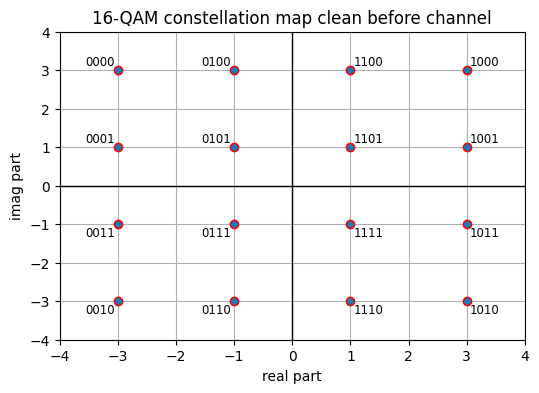

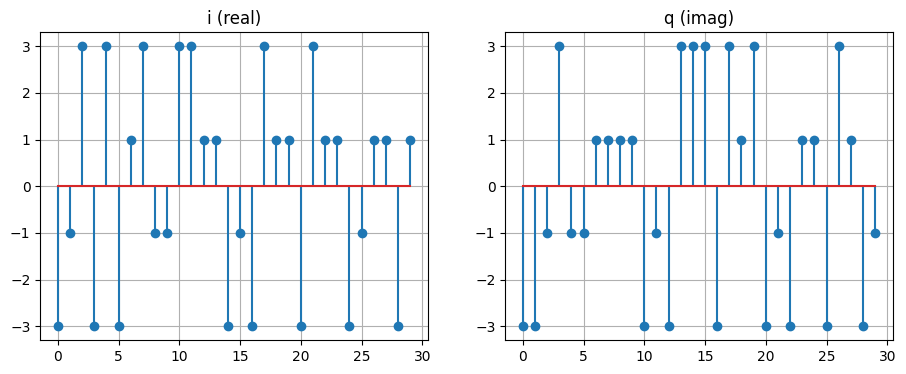

In [233]:
## 1) Modulation
modem = ModulationPy.QAMModem(M_QAM, soft_decision=False)
c_in = modem.modulate(message_s_bin)

assert len(c_in) % N_sc == 0, 'number of symbols must be multiple of N_sc'

# plot

display(Markdown(f"""
## 1) Modulation
$ c[\\cdot] = f_{{MOD}}(s_b) = [c_0, c_1, ... , c_{{N_sc-1}}] $

s.t:
* $ c_i = a_i + jb_i $
* num of symbols: $ N_{{sc}} = {len(c_in)} $
"""))
Visualizer.plot_constellation_map_with_points(c_in, M_QAM, 'clean before channel')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
Visualizer.my_plot(np.real(c_in[0:30]), function='stem', name='i (real)', ax=ax1, hold=1)
Visualizer.my_plot(np.imag(c_in[0:30]), function='stem', name='q (imag)', ax=ax2)



## 2) over sampling

$ \hat c = [c_0, \underbrace{[0, 0, ..., 0]}_{N_{os}-1}, c_1, \underbrace{[0, 0, ..., 0]}_{N_{os}-1}, ..., c_{\hat N}, \underbrace{[0, 0, ..., 0]}_{N_{os}-1}] $

s.t:
* $ \hat c \in \mathbb C^{N_s} $
* $ N_s = N_{sc} \cdot N_{os} = 256 \cdot 16 = 4096 $


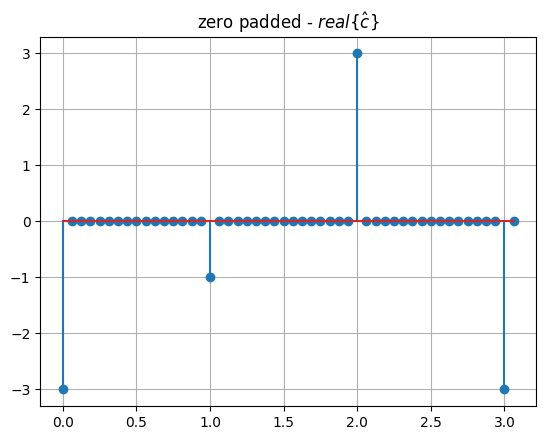

In [234]:
## 2) over sampling
c_in_hat = np.zeros(Ns, dtype=np.complex64)
c_in_hat[::Nos] = c_in

unitless_axis = np.arange(0, len(c_in_hat))/Nos

# plot
display(Markdown(f"""
## 2) over sampling

$ \\hat c = [c_0, \\underbrace{{[0, 0, ..., 0]}}_{{N_{{os}}-1}}, c_1, \\underbrace{{[0, 0, ..., 0]}}_{{N_{{os}}-1}}, ..., c_{{\\hat N}}, \\underbrace{{[0, 0, ..., 0]}}_{{N_{{os}}-1}}] $

s.t:
* $ \\hat c \\in \\mathbb C^{{N_s}} $
* $ N_s = N_{{sc}} \\cdot N_{{os}} = {N_sc} \\cdot {Nos} = {Ns} $
"""))

Visualizer.my_plot(unitless_axis[0:50], np.real(c_in_hat[0:50]), name='zero padded - $ real\{\hat c \} $', function='stem')


## 3) Spectral shaping
* $ u(\xi) = \hat c[\cdot] \ast \psi(\xi) = \mathcal F^{-1}\{C \cdot \Psi \} $
    * input signal $\hat c[\cdot]$:
        * length: $ N_s = 4096$
    * (RRC) pulse filter $\psi(\xi)$:
        * roll-off factor $\beta = 0.2$
        * symbol period $T_s = 1$
        * sampling rate $f_s = N_{os}/T_s = 16.0$
        * length: $N_{\psi} = N_s = 4096 $
    * length $u(\xi): N_u = N_s = 4096 $




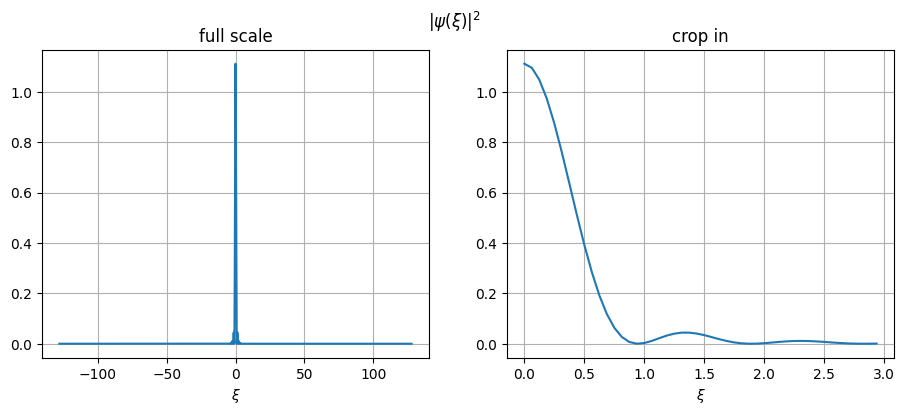

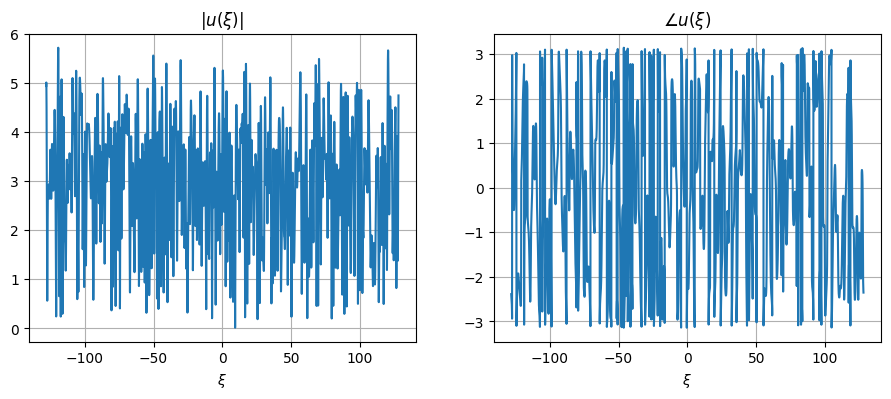

In [235]:
# 3) Spectral shaping
Ts = 1  # symbol period
fs = Nos/Ts


h_ind, psi_xi = rrcosfilter(N=Ns, alpha=bet, Ts=Ts, Fs=fs)
psi_t = np.fft.fft(psi_xi)  # can be saved for efficiency

# u_in = np.convolve(h_rrc, c_in_hat)  # Waveform with PSF
u_in = np.fft.ifft(np.fft.fft(c_in_hat) * psi_t)

assert len(u_in) == Ns, f'len(u_in) = {len(u_in)} != {Ns} = Ns'

# xi axis should be 1/ over sampling
# xi_axis = np.arange(-len(u_in)//2, len(u_in)//2)/Nos

# plot
display(Markdown(f"""
## 3) Spectral shaping
* $ u(\\xi) = \\hat c[\\cdot] \\ast \\psi(\\xi) = \\mathcal F^{{-1}}\{{C \\cdot \\Psi \}} $
    * input signal $\\hat c[\\cdot]$:
        * length: $ N_s = {len(c_in_hat)}$
    * (RRC) pulse filter $\\psi(\\xi)$:
        * roll-off factor $\\beta = {bet}$
        * symbol period $T_s = {Ts}$
        * sampling rate $f_s = N_{{os}}/T_s = {fs}$
        * length: $N_{{\\psi}} = N_s = {Ns} $
    * length $u(\\xi): N_u = N_s = {Ns} $


"""))
zm = range(Ns//2, Ns//2 + Nos*3)
Visualizer.twin_zoom_plot(r'$|\psi(\xi)|^2$', np.abs(psi_xi) ** 2, zm, h_ind, xlabel=r'$\xi$')
Visualizer.plot_amp_and_phase(xi,u_in,r'$\xi$',r'u(\xi)')


## 4) Pre-equalize
* normalizing: $u_1(\xi)= \mu \cdot u(\xi) $
* scaling: $b_1(\xi) = \sqrt{1 - e^{-|u_1 (\xi)|^2} } \cdot e^{j\angle u_1 (\xi)}$
* pre-compensation: $b(\xi) = b_1(\xi) \cdot e^{-j\xi^2L/Z_n}$


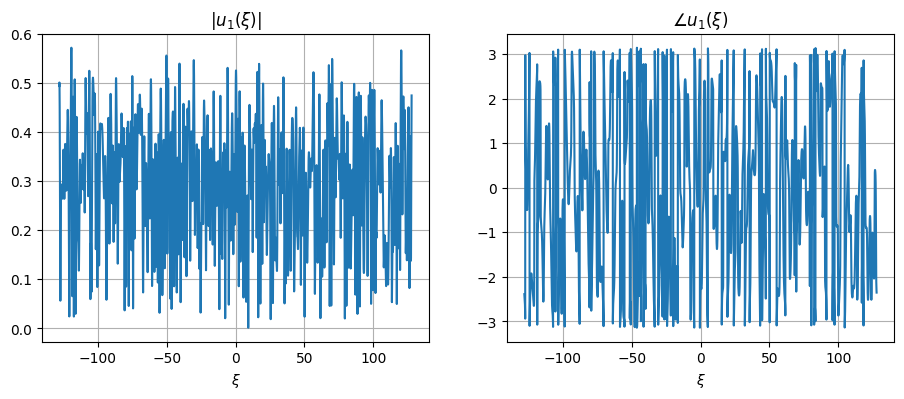

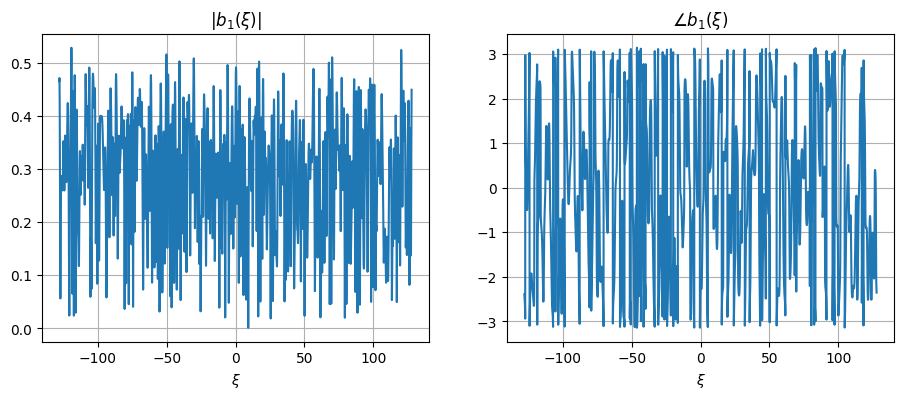

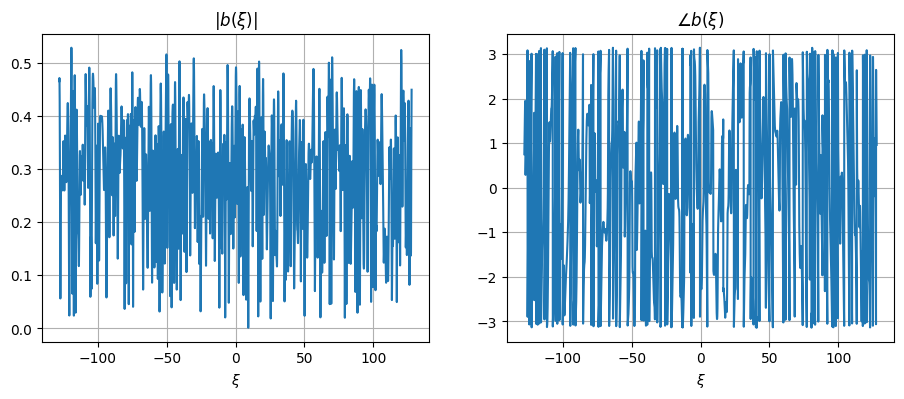

In [236]:
# 4) pre-equalize
# normalizing
u1 = mu*u_in

# #scaling
b_in1 = np.sqrt(1-np.exp(-np.abs(u1)**2))*np.exp(1j*np.angle(u1))

# Pre-compensation
b_in = b_in1*np.exp(-1j*xi**2*(L/Zn))


assert np.all(0 <= np.abs(b_in)) and np.all(np.abs(b_in) <= 1), 'scaled signal is not in the range [0,1]'

# plot
display(Markdown(f"""
## 4) Pre-equalize
* normalizing: $u_1(\\xi)= \\mu \\cdot u(\\xi) $
* scaling: $b_1(\\xi) = \\sqrt{{1 - e^{{-|u_1 (\\xi)|^2}} }} \\cdot e^{{j\\angle u_1 (\\xi)}}$
* pre-compensation: $b(\\xi) = b_1(\\xi) \\cdot e^{{-j\\xi^2L/Z_n}}$
"""))

Visualizer.plot_amp_and_phase(xi,u1, r'$\xi$', r'u_1(\xi)')
Visualizer.plot_amp_and_phase(xi,b_in1, r'$\xi$', r'b_1(\xi)')
Visualizer.plot_amp_and_phase(xi,b_in, r'$\xi$', r'b(\xi)')



## Test 4) descaling and denormalizing

* post compensation: $\hat b_1 = b \cdot e^{i \xi^2 L/Z_n}$
* descaling: $\hat u_1 = \sqrt{-\log(1-|\hat b_1|^2)} \cdot e^{i \angle \hat b_1}$
* denormalizing: $\hat u = \hat u_1/\mu$


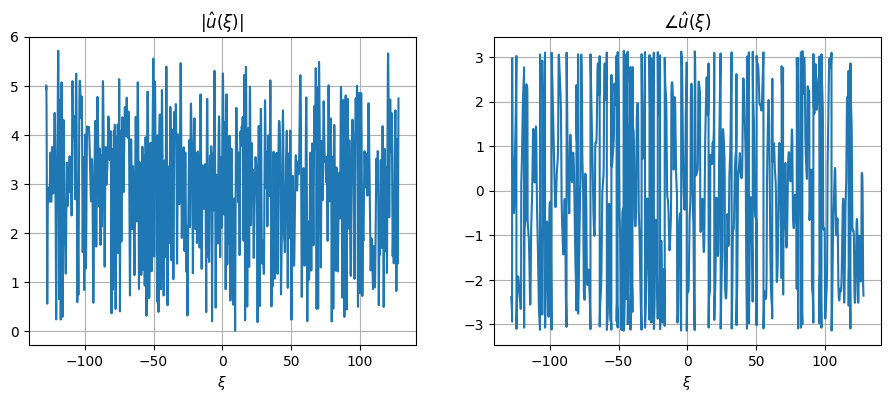

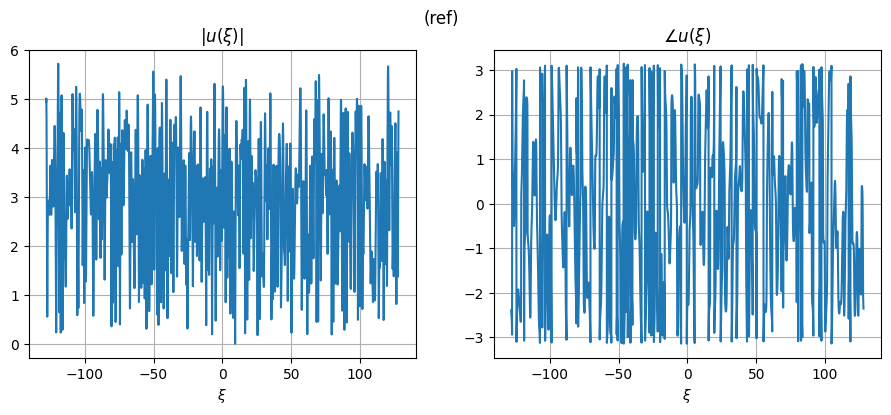

In [237]:
# test - reverse scaling


# post compensation
b_out = b_in * np.exp(1j*xi**2*(L/Zn))

# descale
u1_out_test = np.sqrt(-np.log(1 - np.abs(b_out)**2)) * np.exp(1j * np.angle(b_out))

# normalize
u_out_test = u1_out_test / mu

assert np.allclose(u_out_test, u_in), 'test failed'

# plot
display(Markdown(f"""
## Test 4) descaling and denormalizing

* post compensation: $\\hat b_1 = b \\cdot e^{{i \\xi^2 L/Z_n}}$
* descaling: $\\hat u_1 = \\sqrt{{-\\log(1-|\\hat b_1|^2)}} \\cdot e^{{i \\angle \\hat b_1}}$
* denormalizing: $\\hat u = \\hat u_1/\\mu$
"""))

Visualizer.plot_amp_and_phase(xi,u_out_test, r'$\xi$', r'\hat{u}(\xi)')
Visualizer.plot_amp_and_phase(xi,u_in, r'$\xi$', r'u(\xi)', '(ref)')


## 4.5) zero padding
extend $b(\xi)$ from length $N_s$ to length of $N_{NFT}$

$ b_p = \underbrace{[0,0,...,0]}_{(N_{NFT}-N_s)/2} \oplus b(\xi) \oplus \underbrace{[0,0,...,0]}_{(N_{NFT}-N_s)/2}$

where
* length of $b(\xi)$: $ N_s = 4096$
* length of $b_p(\xi)$: $N_{NFT} = 16384$


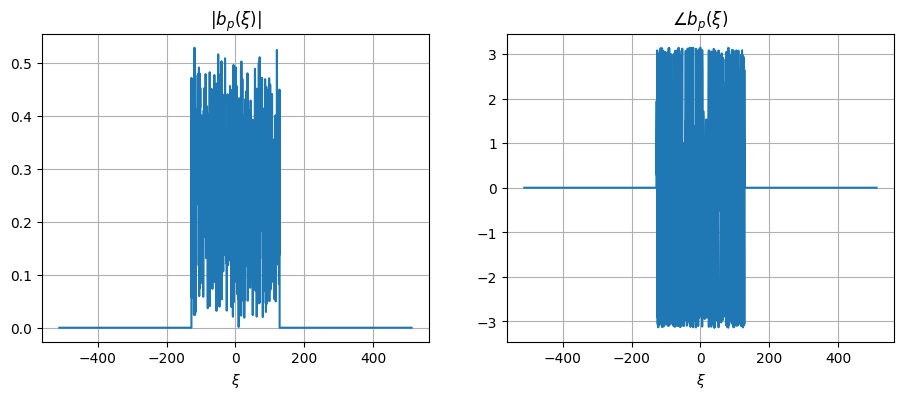

In [238]:
pad_l = ((Nnft-Ns))//2
pad_r = ((Nnft-Ns))//2
b_in_padded = np.pad(b_in, (pad_l, pad_r), mode='constant', constant_values=0)
display(Markdown(f"""
## 4.5) zero padding
extend $b(\\xi)$ from length $N_s$ to length of $N_{{NFT}}$

$ b_p = \\underbrace{{[0,0,...,0]}}_{{(N_{{NFT}}-N_s)/2}} \\oplus b(\\xi) \\oplus \\underbrace{{[0,0,...,0]}}_{{(N_{{NFT}}-N_s)/2}}$

where
* length of $b(\\xi)$: $ N_s = {Ns}$
* length of $b_p(\\xi)$: $N_{{NFT}} = {Nnft}$
"""))
Visualizer.plot_amp_and_phase(xi_padded,b_in_padded, r'$\xi$', r'b_p(\xi)')


## 5) INFT
$q(t) = \mathcal F^{-1}\{b_p(\xi)\}$                 
$ \qquad  N_t = D = \lceil N_\xi \rceil = 16384 $


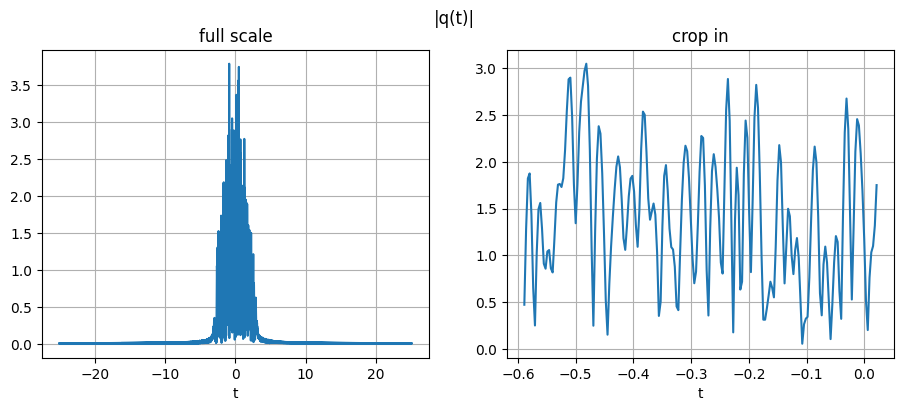

In [239]:
# INFT2 (params from matlab)

contspec = b_in_padded
bound_states = []
discspec = []
cst = 1  # continuous spectrum type - default is None
dst = 0  # default is None


res = nsev_inverse(xi_padded, t_padded, contspec, bound_states, discspec,
                   cst=cst, dst=dst)
q_in = res['q']


# plot
display(Markdown(f"""
## 5) INFT
$q(t) = \\mathcal F^{{-1}}\\{{b_p(\\xi)\\}}$                 
$ \\qquad  N_t = D = \\lceil N_\\xi \\rceil = {Nnft} $
"""))

Visualizer.twin_zoom_plot('|q(t)|', np.abs(q_in), range(8000, 8200), t_padded, 't')


## 5.5) cropping to center
we will keep $N_b$ samples from the center of $q(t)$
                 
$ q_b(t) = q[\frac{N_{NFT}-N_b}{2} : \frac{N_{NFT}+N_b}{2}] $
* $ N_b = T_b/\Delta t = 2458 $

* $ \Delta t = 4.17 $


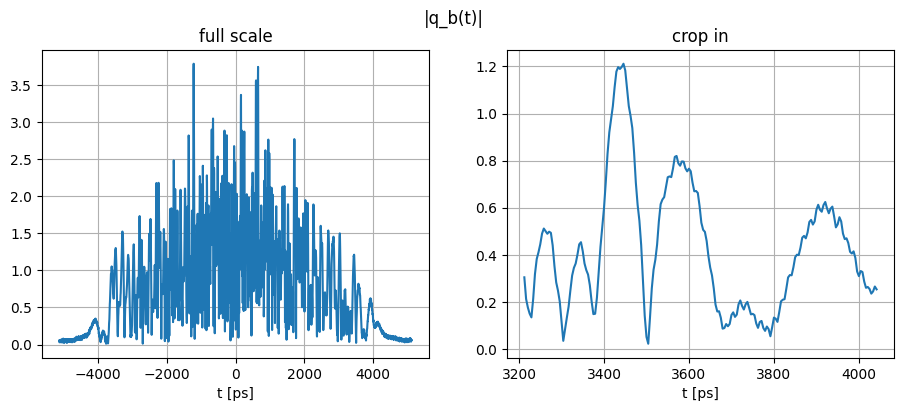

In [240]:
qb = q_in[(Nnft-Nb)//2:(Nnft+Nb)//2]

display(Markdown(f"""
## 5.5) cropping to center
we will keep $N_b$ samples from the center of $q(t)$
                 
$ q_b(t) = q[\\frac{{N_{{NFT}}-N_b}}{{2}} : \\frac{{N_{{NFT}}+N_b}}{{2}}] $
* $ N_b = T_b/\\Delta t = {Nb} $

* $ \\Delta t = {dt:.2f} $
"""))
Visualizer.twin_zoom_plot('|q_b(t)|', np.abs(qb), range(2000, 2200), t, 't [ps]')




## 5.6) converting to the r.w.u
$ q_{physical} = q_b(t) \cdot \sqrt{P_n} $


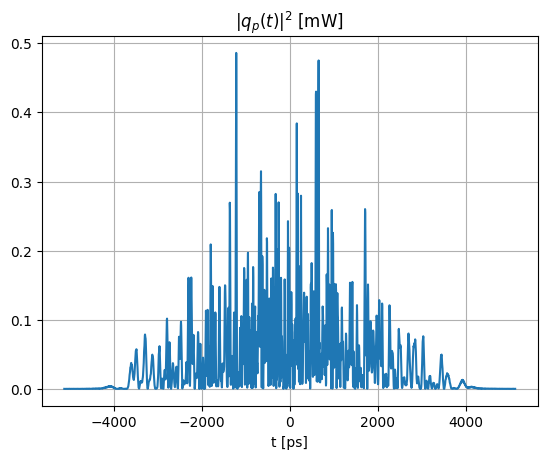

In [241]:
# converting to the r.w.u (physical units)
q_p = qb*np.sqrt(Pn)

display(Markdown(f"""
## 5.6) converting to the r.w.u
$ q_{{physical}} = q_b(t) \\cdot \\sqrt{{P_n}} $
"""))
power_q_mw = np.abs(q_p)**2*1e3 # power in [mW]
Visualizer.my_plot(t, power_q_mw, name=r'$|q_p(t)|^2$ [mW]', xlabel='t [ps]')



SSF params: N = 439



## 6) Split Step Fourier
$ q_p(t) \rightarrow \boxed{SSF} \rightarrow q_z(t) $
#### params:
* $ \beta_2 = -21 [ps^2/km] $
* $ \gamma = 1.27 [1/km \cdot W] $
* $ T_0 = 5120.0 [ps] $
* $ \Delta t = 4.17 [ps] $
* $ L_a = 80 [km] $
* $ \Delta z = 0.2 [km] $

#### algorithm - TODO: verify correctness (both math and code)
* $a\in \mathbb{C}^{N_t}$
* $a = a \cdot \sqrt{P_0}$
* $w = [0,...,\frac{N_t}{2}-1,\frac{-N_t}{2},...,-1] \cdot \frac{2 \pi}{N_t \cdot dt}$
* $ v_1 = \exp\left(\frac{j \cdot \beta_2}{2} \cdot w^2 \cdot \frac{\Delta_z}{2}\right) $
* $a = \mathcal{F}(a)$
* Loop $N=\frac{Z_N}{\Delta_z}$ times:
    * $a = \mathcal{F}^{-1}(a \cdot v_1)$
    * $n\in\mathbb{C}^{N_t} \sim N(0,1)$
    * $a = a + \sqrt{\frac{D\cdot \Delta_z}{dt}}\cdot n$
    * $a = a \cdot \exp\left(j \cdot \gamma \cdot \Delta_z \cdot |a|^2\right)$
    * $a = v_1 \cdot \mathcal{F}(a)$
* $a = \mathcal{F}^{-1}(a)$
* $a = a \cdot \frac{1}{\sqrt{P_0}}$


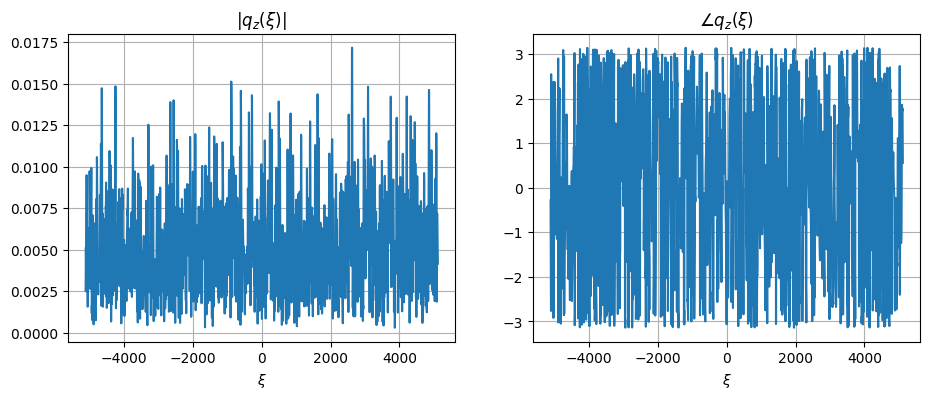

In [242]:
ssf = SplitStepFourier(
    b2=beta2,
    gamma=gamma,
    t0=T0,
    dt=dt,
    # z_n=La, # <~~~~~~~~~~~~~~~~~~~ NEEDS TO BE RESTORED
    # dz=dz,
    z_n=Zn,
    dz=200,
    with_noise=True,
    verbose=True
)

qz = ssf(q_p)

display(Markdown(f"""
## 6) Split Step Fourier
$ q_p(t) \\rightarrow \\boxed{{SSF}} \\rightarrow q_z(t) $
#### params:
* $ \\beta_2 = {beta2} [ps^2/km] $
* $ \\gamma = {gamma} [1/km \\cdot W] $
* $ T_0 = {T0} [ps] $
* $ \\Delta t = {dt:.2f} [ps] $
* $ L_a = {La} [km] $
* $ \\Delta z = {dz} [km] $

#### algorithm - TODO: verify correctness (both math and code)
* $a\\in \\mathbb{{C}}^{{N_t}}$
* $a = a \\cdot \\sqrt{{P_0}}$
* $w = [0,...,\\frac{{N_t}}{{2}}-1,\\frac{{-N_t}}{{2}},...,-1] \\cdot \\frac{{2 \\pi}}{{N_t \\cdot dt}}$
* $ v_1 = \\exp\\left(\\frac{{j \\cdot \\beta_2}}{{2}} \\cdot w^2 \\cdot \\frac{{\\Delta_z}}{{2}}\\right) $
* $a = \\mathcal{{F}}(a)$
* Loop $N=\\frac{{Z_N}}{{\\Delta_z}}$ times:
    * $a = \\mathcal{{F}}^{{-1}}(a \\cdot v_1)$
    * $n\\in\\mathbb{{C}}^{{N_t}} \\sim N(0,1)$
    * $a = a + \\sqrt{{\\frac{{D\\cdot \\Delta_z}}{{dt}}}}\\cdot n$
    * $a = a \\cdot \\exp\\left(j \\cdot \\gamma \\cdot \\Delta_z \\cdot |a|^2\\right)$
    * $a = v_1 \\cdot \\mathcal{{F}}(a)$
* $a = \\mathcal{{F}}^{{-1}}(a)$
* $a = a \\cdot \\frac{{1}}{{\\sqrt{{P_0}}}}$
"""))

Visualizer.plot_amp_and_phase(t, qz, r'$\xi$', r'q_z(\xi)')
# Visualizer.twin_zoom_plot('real X(xi)', np.real(x6), range(4000, 4200))


## 6.5) descaling and padding:
* rescale the pulse to soliton units 
    * $ q_s(t) = q_z(t) / \sqrt{P_n} $
* pad the pulse to length of $N_{NFT}$
    * $ q_{pad}(t) = [0,0,...,0] \oplus q_s(t) \oplus [0,0,...,0] $
    * $ N_{pad} = N_{NFT} = 16384 $
    * $ t_{padded} \in [\frac{-N_{NFT}}{2}, \frac{N_{NFT}}{2}] \cdot \Delta t = [-34133.33, 34133.33] $


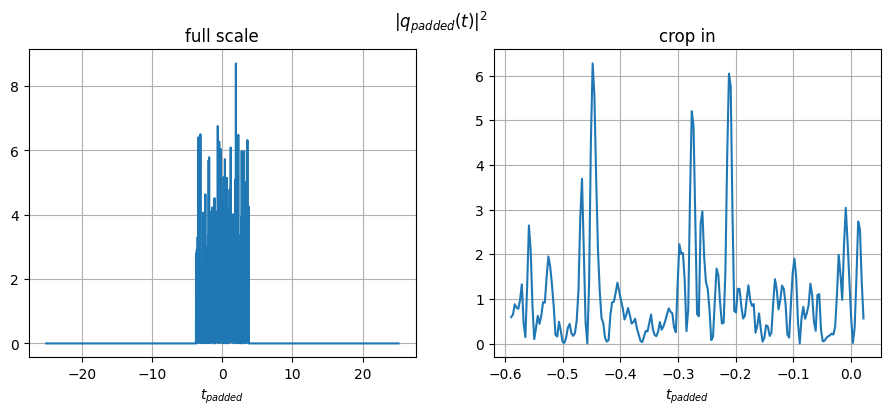

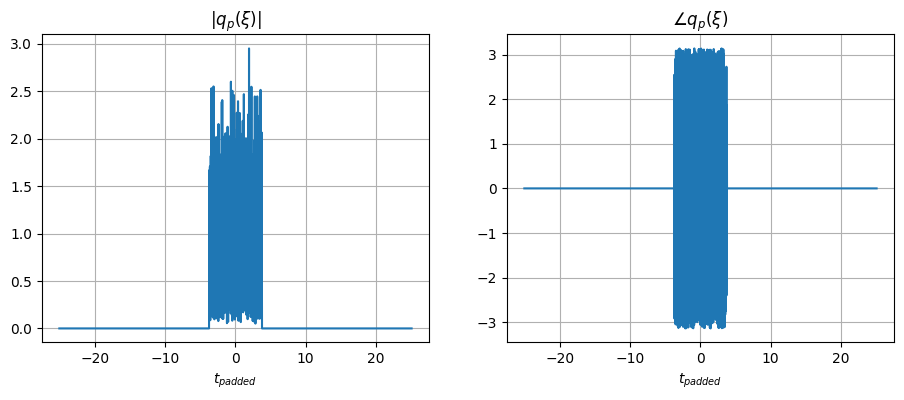

In [243]:
# 6.5) descaling and padding:
q_s = qz/np.sqrt(Pn) # rescale to soliton units

assert Nnft > Nb, 'Nnft must be larger than Nb'

q_pad = np.pad(q_s, (((Nnft-Nb))//2, ((Nnft-Nb))//2), mode='constant', constant_values=0) # pad to length of N_NFT
# t_padded = np.arange(-Nnft//2, Nnft//2)*dt # TODO: check if this is correct
    
display(Markdown(f"""
## 6.5) descaling and padding:
* rescale the pulse to soliton units 
    * $ q_s(t) = q_z(t) / \\sqrt{{P_n}} $
* pad the pulse to length of $N_{{NFT}}$
    * $ q_{{pad}}(t) = [0,0,...,0] \\oplus q_s(t) \\oplus [0,0,...,0] $
    * $ N_{{pad}} = N_{{NFT}} = {Nnft} $
    * $ t_{{padded}} \\in [\\frac{{-N_{{NFT}}}}{{2}}, \\frac{{N_{{NFT}}}}{{2}}] \\cdot \\Delta t = [{-Nnft//2*dt:.2f}, {Nnft//2*dt:.2f}] $
"""))
Visualizer.twin_zoom_plot(r'$|q_{padded}(t)|^2$',
                          np.abs(q_pad)**2,
                          range(8000,8200),
                          t_padded, r'$t_{padded}$')
Visualizer.plot_amp_and_phase(t_padded, q_pad, r'$t_{padded}$', r'q_p(\xi)')


## 7) NFT
Forward NFT back to $\xi$ domain
                 
$ \hat b_{pad}(\xi) = \mathcal F \{ q_{pad}(t) \} $


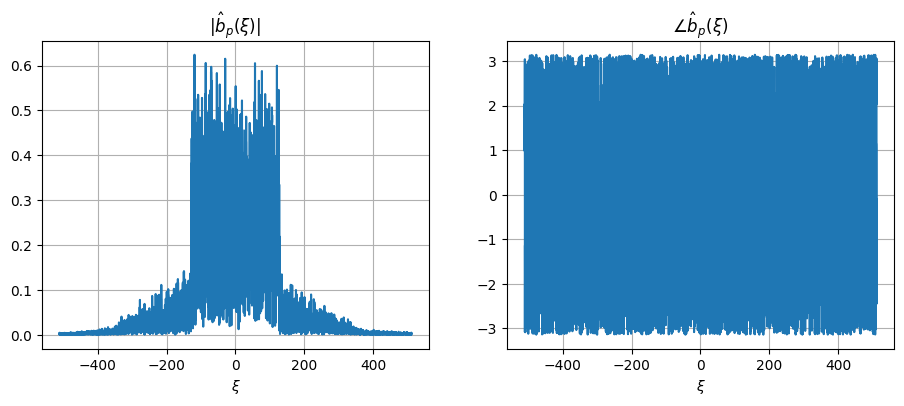

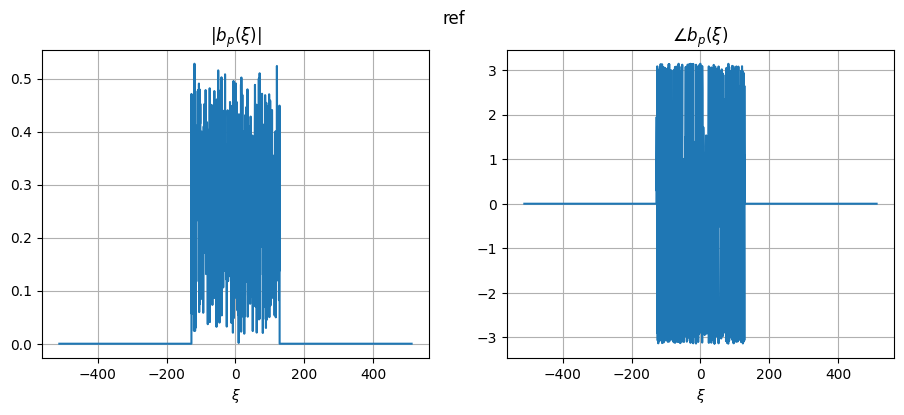

In [250]:
res = nsev(q_pad, t_padded, Xi1=XI[0], Xi2=XI[1],
           M=Nnft, display_c_msg=True, cst=cst)
assert res['return_value'] == 0, "NFT failed"
b_out_padded = res['cont_b']

# x7 = x7 * np.exp(-1j * xivec**2 * (L))

display(Markdown(f"""
## 7) NFT
Forward NFT back to $\\xi$ domain
                 
$ \\hat b_{{pad}}(\\xi) = \\mathcal F \\{{ q_{{pad}}(t) \\}} $
"""))

Visualizer.plot_amp_and_phase(xi_padded, b_out_padded, r'$\xi$', r'\hat b_p(\xi)')
Visualizer.plot_amp_and_phase(xi_padded, b_in_padded, r'$\xi$', r'b_p(\xi)', 'ref')


## 7.5) cropping to center
we will keep $N_s$ samples from the center of $\hat b_{pad}(\xi)$

$ \hat b(\xi) = \hat b_{pad}[\frac{N_{NFT}-N_s}{2} : \frac{N_{NFT}+N_s}{2}] $
* $ N_s = 4096 $


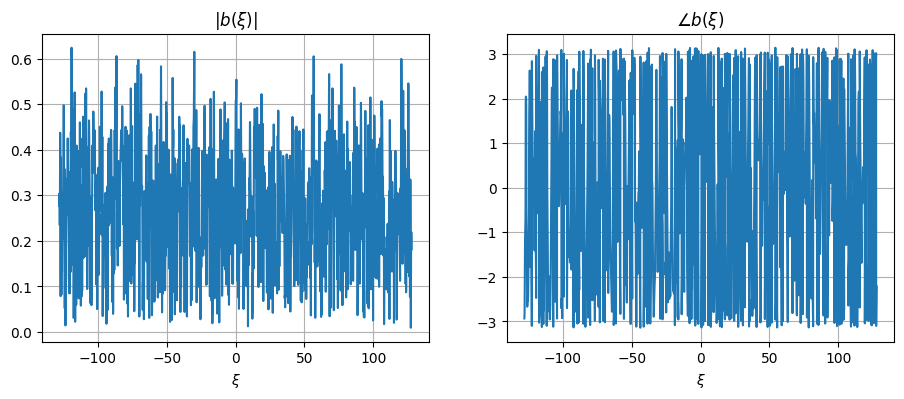

In [249]:
## 7.5 cropping to center
b_out = b_out_padded[(Nnft-Ns)//2:(Nnft+Ns)//2]

display(Markdown(f"""
## 7.5) cropping to center
we will keep $N_s$ samples from the center of $\\hat b_{{pad}}(\\xi)$

$ \\hat b(\\xi) = \\hat b_{{pad}}[\\frac{{N_{{NFT}}-N_s}}{{2}} : \\frac{{N_{{NFT}}+N_s}}{{2}}] $
* $ N_s = {Ns} $
"""))
Visualizer.plot_amp_and_phase(xi, b_out, r'$\xi$', r'b(\xi)')


## 8) Equalize
* post compensation: $\hat b(\xi) = b(\xi) \cdot e^{i \xi^2 L/Z_n}$
* descaling: $\hat u_1(\xi) = \sqrt{-\log(1-|\hat b(\xi)|^2)} \cdot e^{i \angle \hat b(\xi)}$
* denormalizing: $\hat u(\xi) = \hat u_1(\xi)/\mu$


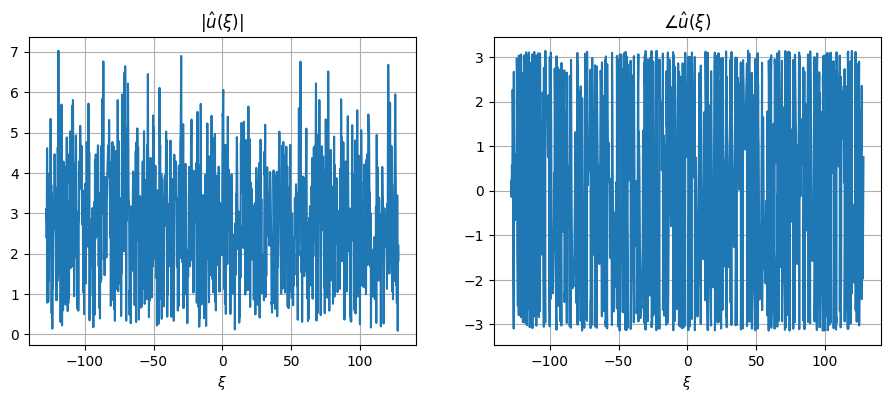

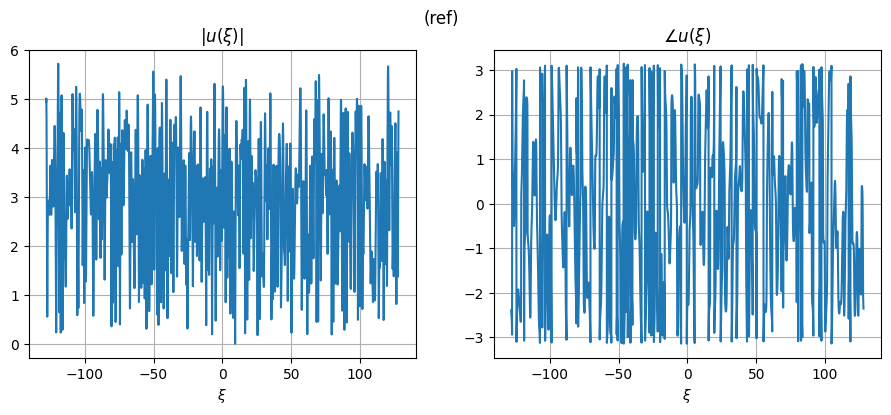

In [253]:
# 8) Equalize

# post compensation
b_out = b_out * np.exp(-1j*xi**2*(L/Zn)) # PLUS OR MINUS??

# descale
u1_out = np.sqrt(-np.log(1 - np.abs(b_out)**2)) * np.exp(1j * np.angle(b_out))

# de-normalize
u_out = u1_out / mu

display(Markdown(f"""
## 8) Equalize
* post compensation: $\\hat b(\\xi) = b(\\xi) \\cdot e^{{i \\xi^2 L/Z_n}}$
* descaling: $\\hat u_1(\\xi) = \\sqrt{{-\\log(1-|\\hat b(\\xi)|^2)}} \\cdot e^{{i \\angle \\hat b(\\xi)}}$
* denormalizing: $\\hat u(\\xi) = \\hat u_1(\\xi)/\\mu$
"""))

Visualizer.plot_amp_and_phase(xi,u_out, r'$\xi$', r'\hat u(\xi)')
Visualizer.plot_amp_and_phase(xi,u_in, r'$\xi$', r'u(\xi)', '(ref)')

### 9) Match Filter
convolve again with the rrc filter and sample every $ N_{over sample}=8 $ points, those points are free from inter symbol interference (aliasing)

* $ \hat{\tilde{c}} = \tilde{u} \circledast \psi $
* $ \hat{c}[n] = \hat{\tilde{c}}[nN_{os}] / N_{os} $


## 9) Match Filter
convolve again with the rrc filter and sample every $ N_{os}=16 $ points, those points are free from inter symbol interference (aliasing)            
* $ \hat{c}_1 = \hat{u}(\xi) \ast \psi(\xi) = \mathcal F^{-1}\{U \cdot \Psi \} $
* $ \hat{c}[n] = \hat{c}_1[nN_{os}] / N_{os} $
* $ N_{os} = 16 $


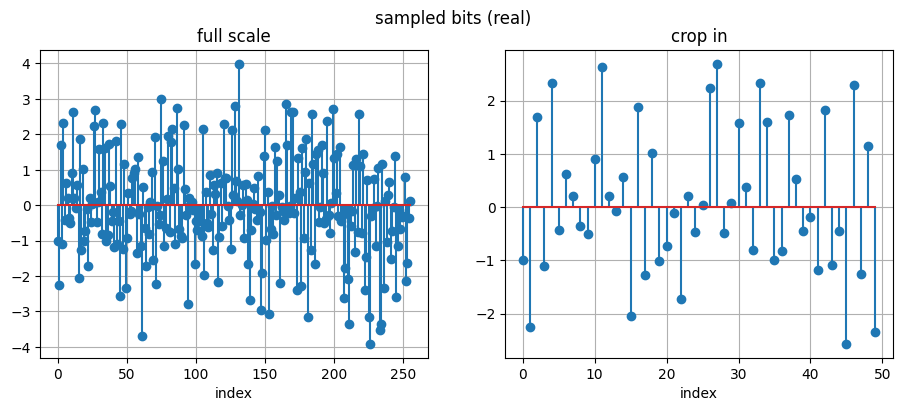

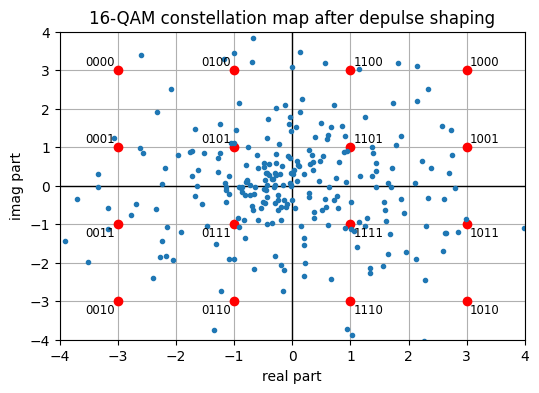

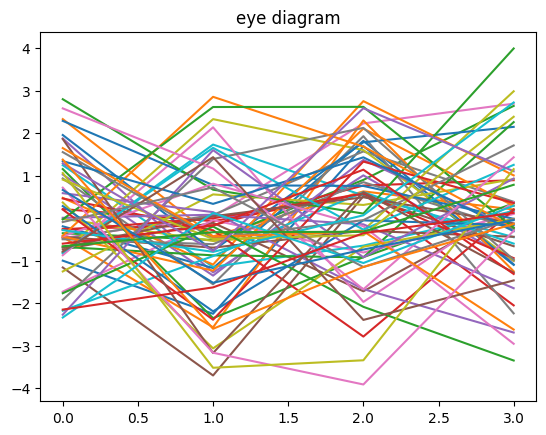

In [261]:
## 9) match filter

# convolve with RRC
c_out1 = np.fft.ifft(np.fft.fft(psi_xi)*np.fft.fft(u_out))


# downsample
start = 0
stop = Ns  # + over_sampling
step = Nos
c_out = c_out1[start:stop:step] / Nos

display(Markdown(f"""
## 9) Match Filter
convolve again with the rrc filter and sample every $ N_{{os}}={Nos} $ points, those points are free from inter symbol interference (aliasing)            
* $ \\hat{{c}}_1 = \\hat{{u}}(\\xi) \\ast \\psi(\\xi) = \\mathcal F^{{-1}}\{{U \\cdot \\Psi \}} $
* $ \\hat{{c}}[n] = \\hat{{c}}_1[nN_{{os}}] / N_{{os}} $
* $ N_{{os}} = {Nos} $
"""))

Visualizer.twin_zoom_plot('sampled bits (real)',np.real(c_out),range(0,50),function='stem')
Visualizer.plot_constellation_map_with_points(c_out, M_QAM, 'after depulse shaping')
Visualizer.eye_diagram(c_out, sps=sps)

### 10) demodulation
restore back from i q symbols to bits

In [262]:
s_out = modem.demodulate(c_out)

#plot
Visualizer.print_bits(s_out, sps, 'message after channel')


_______________________________________________
message after channel - len=1024
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 1. 1. 1.]
 ...
 [0. 1. 0. 1.]
 [0. 1. 1. 1.]
 [1. 1. 0. 1.]]


### Evaluate:
calculate ber

In [263]:
num_errors = (message_s_bin != s_out).sum()
ber = num_errors / Ns

print(f'ber = {ber} = {num_errors}/{Ns}')


ber = 0.115966796875 = 475/4096
